In [116]:
import time
import numpy as np
from scipy.integrate import odeint


def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [117]:
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [118]:
#r = odeint(vectors2, r0, t, args=(I, J))
#r = ode(f, jac).set_integrator('zvode', method='bdf').set_initial_value(r0, 0)

In [119]:
#r.set_initial_value(r0, 0)#.set_f_params(2.0).set_jac_params(2.0)

In [120]:
import matplotlib.pyplot as plt

In [121]:
Gamma_ud=0.4
Gamma_du=0.2
Gamma_el=1.6


gammaplus=Gamma_du/2
gammaminus=Gamma_ud/2
gammaz=Gamma_el/8


Dissipation_factor=1


Gamma=np.array(Dissipation_factor*[gammaplus,gammaminus,gammaz])  #[gamma+,gamma-,gammaz]

rho_init0=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |+><+|


def trace(A):
    return np.trace(A)

def matmu(A,B):
    return np.matmul(A,B)

#rho_init1=np.array([[1,0],[0,0]])    #By default
#rho_init2=np.array([[1,0],[0,0]])    #By default




N=5




sigma_p= np.array([[0,1],[0,0]])
sigma_m= np.array([[0,0],[1,0]])
sigma_z= np.array([[1,0],[0,-1]])


##Initial values one operator

sp_init0=trace(matmu(rho_init0,sigma_p))
sz_init0=trace(matmu(rho_init0,sigma_z))
sm_init0=trace(matmu(rho_init0,sigma_m))

Genit=[sp_init0,sz_init0,sm_init0]


r0=[]
fact=int(N*(N-1)/2)

r0=[Genit[0]]*N+[Genit[1]]*N+[Genit[0]**2]*fact+[Genit[0]*Genit[2]]*fact+[Genit[0]*Genit[1]]*2*fact+[Genit[1]**2]*fact

#Random interaction matrix

#A=np.random.rand(N,N)
#A= np.triu(A)
#np.fill_diagonal(A, 0)

In [122]:
#Homogeneous interaction matrix

Jef=3

A=np.ones((N,N))
A= np.triu(A)
np.fill_diagonal(A, 0)
A=Jef*A/N

In [123]:
def del_list(N):
    
    s=[]
    count=0
    for j in range (0,N):
        s.append((count)%N)
        count=count+1
    
    s_fin=s*(N) 

    count=0
    while count<len(s_fin):
        del(s_fin[count])
        count=count+N
    
    sfin=np.array(s_fin)
    
    return sfin

def new_indexer(N):
    s=[]
    for j in range(N):
        s=s+[j]*(N-1)
    return np.array(s)

def up_triang(N):
    ar = np.array(np.zeros((N,N)))
    indices = np.triu_indices_from(ar)
    indexer=[]
    for j in range(len(indices[0])):
        if indices[0][j]!=indices[1][j]:
            indexer.append([indices[0][j],indices[1][j]])
    return np.array(indexer)+N    

In [124]:
# If you want to get the index of the upper triangular matrix just do this up_triang(N)-N 



In [125]:
def index_p(Arr,ind):
    return np.array([i for i, e in enumerate(Arr) if e == ind])+int(2*N+N*(N-1))   #return the indexes required for dpdt

In [126]:
def computeLM(N):
    i = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)),dtype = 'complex_')
    r0=[]
    extern=np.zeros(int(N*(5*N-1)/2))
    
    
    Indexer=del_list(N)
    new_index=new_indexer(N)
    
    
    for j in range (0,N):  #dpdt
        i[j][j]=-(Gamma[0]+Gamma[1]+4*Gamma[2])
        for w in index_p(del_list(N),j):
            i[j][w]=2*1j*(A[j][new_index[w-int(2*N+N*(N-1))]]+A[new_index[w-int(2*N+N*(N-1))]][j])   #   
        
    for j in range (N,2*N): #dzdt
        i[j][j]=-2*(Gamma[0]+Gamma[1])
        extern[j]=2*(Gamma[0]-Gamma[1])

    for j in range (2*N,int(2*N+N*(N-1)/2)):  #dpadpbdt
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    for j in range (int(2*N+N*(N-1)/2),int(2*N+N*(N-1))):  #dpadmbdt
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    
    
    count=0
    for j in range (int(2*N+N*(N-1)),int(2*N+2*N*(N-1))):   #dzadpbdt
        i[j][j]=-(3*(Gamma[0]+Gamma[1])+4*Gamma[2])
        i[j][Indexer[count]]=2*(Gamma[0]-Gamma[1])+2*1j*(A[Indexer[count]][new_index[count]]+A[new_index[count]][Indexer[count]])   #I use Jef for now
        count=count+1
        
    
    count=0        
    for j in range (int(2*N+2*N*(N-1)),int(2*N+5*N*(N-1)/2)):   #dzadzbdt
        i[j][j]=-4*(Gamma[0]+Gamma[1]) 
        i[j][up_triang(N)[count][0]]=-2*(Gamma[1]-Gamma[0])
        i[j][up_triang(N)[count][1]]=-2*(Gamma[1]-Gamma[0])
        count=count+1
        
    return extern, i

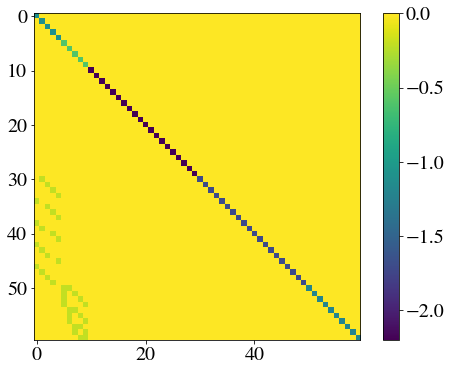

In [127]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.real(computeLM(N)[1]))
plt.colorbar()
plt.show()




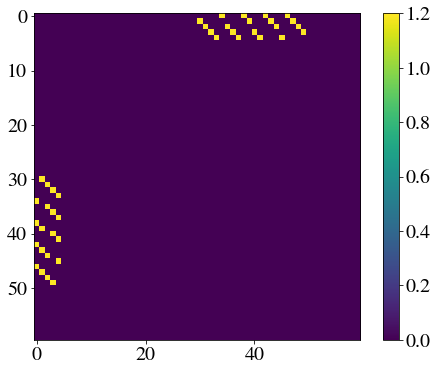

In [128]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.imag(computeLM(N)[1]))
plt.colorbar()
plt.show()


In [129]:
arr=del_list(N)
def index_zp(a,b,arr):
    return list(arr[a*(N-1):]).index(b)+a*(N-1)

In [130]:
def indexzz(a,b,arry):
    if a<b:
        return arry.tolist().index([a,b])+2*(N**2)
    elif a>b:
        return arry.tolist().index([b,a])+2*(N**2)

In [131]:
def vectors2(r, t, extern, i):
    s = i @ r  #Vector multiplication
    drdt = s+extern
    
    restr=N**2+N
    arr_in = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)),dtype = 'complex_')
    a_list = np.array(list(range( N)))
    triang_ind=up_triang(N)-N
    arr=del_list(N)
    
    
    count=0
    
    init_in=N**2+N
    
    init1_in=2*(N**2)
    
    for j1 in range (2*N,int(2*N+N*(N-1)/2)):  #dpadpbdt
        a0=triang_ind[count][0]
        a1=triang_ind[count][1]
        index_ab=index_zp( a0 ,a1,arr)
        abz_ind=index_ab+init1_in
        
        j1pm=j1+int(N*(N-1)/2)
        
        
        
        
        for ju in np.array(list(set(a_list) - set(triang_ind[count]))): 
            
            index_0=index_zp( ju ,a0,arr)
            index_1=index_zp( ju ,a1,arr)
            
            index_0per=index_zp( a0,ju,arr)
            index_1per=index_zp( a1 ,ju,arr)
            
            
            coef0=A[ju][a0]+A[a0][ju]+A[ju][a1]+A[a1][ju]
            
            
            arr_in[j1][j1]=arr_in[j1][j1]+r[ju+N]*2j* coef0
            #print(j1,j1,".",ju+N,".","|",ju,a0,a0,ju,ju,a1,a1,ju)
            
            arr_in[j1][a0]=arr_in[j1][a0]+ 2j* (r[init_in+index_1] -2*r[a1]*r[ju+N])  *coef0
            #print(j1,a0,".",init_in+index_1,".andMinus2",a1,ju+N,"|",ju,a0,a0,ju,ju,a1,a1,ju)
            
            
            arr_in[j1][a1]=arr_in[j1][a1]+ 2j* r[init_in+index_0]  *coef0
            #print(j1,a1,".",init_in+index_0,"|",ju,a0,a0,ju,ju,a1,a1,ju)
        

            
            ab_ind=init_in+index_0
            
            
            coef1=(-A[ju][a0]-A[a0][ju]+A[ju][a1]+A[a1][ju])
            
            arr_in[j1pm][j1pm]=arr_in[j1pm][j1pm]+r[ju+N]*(-2j)* coef1
            #print(j1pm,j1pm,".",ju+N,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            arr_in[j1pm][ab_ind]=arr_in[j1pm][ab_ind]+(-2j)*np.conjugate(r[a1])*coef1
            #print(j1pm,ab_ind,".conj",a1,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            arr_in[j1pm][a0]=arr_in[j1pm][a0]+  (-2j)*(np.conjugate(r[init_in+index_1])   - 2*np.conjugate(r[a1])*r[ju+N] ) *coef1
            #print(j1pm,a0,".conj",init_in+index_1,"-","conj",a1,ju+N,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            
        count=count+1        
        

        
        
        
        
        
        for j in range(int(N**2+N),2*N**2):
        
            a=new_indexer(N)[j-restr]
            b=del_list(N)[j-restr]
        
        

            
            
            for ru in np.array(list(set(a_list) - set([a,b]))):
                
                
                
                inzp=index_zp(ru,b,arr)+N**2+N
                inzz=indexzz(a,ru,triang_ind) 
                coefb=(A[ru][b]+A[b][ru])
                
                

                arr_in[j][j]=arr_in[j][j]+r[ru+N]*2j* coefb


                arr_in[j][inzp]=arr_in[j][inzp]+ 2j* coefb *  r[a+N] 
                

                
                arr_in[j][inzz]=arr_in[j][inzz]+ 2j* coefb*  r[b] 
                
                
                arr_in[j][ru+N]=arr_in[j][ru+N]+ 2j* coefb*(-2* r[a+N]* r[b])
            
    
    
    
    
    s1=  arr_in @ r       
    drdt=drdt+ s1   
    
    return drdt

In [132]:
import time 

t0=time.time()
extern, i = computeLM(N)

t = np.linspace(0, 8, 5000)

r = odeintz(vectors2, r0, t, args=(extern, i))


t1=time.time()

print(t1-t0," "+str(N)," "+str((t1-t0)/(N*(5*N-1)/2)) )

30.61084508895874  5  0.5101807514826456


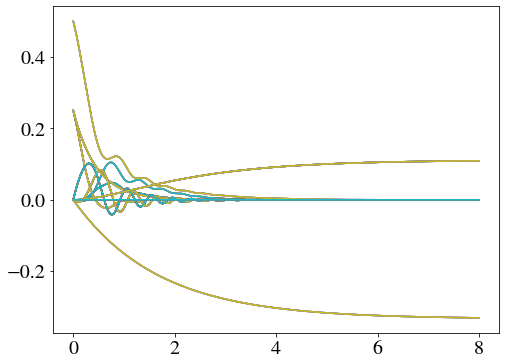

In [133]:
for j in range(int(N*(5*N-1)/2)):
    plt.plot(t,np.real(r[:,j]))
    plt.plot(t,np.imag(r[:,j]))


In [ ]:
def tin(a):
            if a=="xx":
                return 0
            elif a=="xy":
                return 1
            elif a=="xz" :
                return 2
            elif a=="yx":
                return 3
            elif a=="yy":
                return 4
            elif a=="yz":
                return 5
            elif a=="zx":
                return 6
            elif a=="zy":
                return 7
            elif a=="zz":
                return 8

In [101]:
def vectors2(t,N):       
    
    
    arr_in = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)))
    a_list = np.array(list(range( N)))
    triang_ind=up_triang(N)-N
    arr=del_list(N)
    
    
    count=0
    
    init_in=N**2+N
    
    init1_in=2*(N**2)
    
    
    
    
        
    goun=0
    
    print("here")
        
    
    
    
    restr=N**2+N

    
    
    
    
    
        
        
        
    for j in range(int(N**2+N),2*N**2):  
        
        a=new_indexer(N)[j-restr]
        b=del_list(N)[j-restr]
        princ= j   
            
            
        for ru in np.array(list(set(a_list) - set([a,b]))):
                
                
                
            inzp=index_zp(ru,b,arr)+N**2+N
            inzz=indexzz(a,ru,triang_ind)    
                
            #arr_in[princ][princ]=arr_in[princ][princ]+r[ru+N]*2j* (A[ru][b]+A[b][ru])
                
            print(princ,princ,ru+N,"|",ru,b,b,ru)
            

            
            #arr_in[princ][inzp]=arr_in[princ][inzp]+ 2j* (A[ru][b]+A[b][ru]) * (  r[a+N] -2* r[b]*r[ru+N] )
            
            print(princ,inzp,a+N,"|",ru,b,b,ru)
            
            print(princ,inzz,b,"|",ru,b,b,ru)
            
            print(princ,ru+N,"|-2",a+N,b,"coef",ru,b,b,ru)
            
            
            
            
            #arr_in[princ][inzz]arr_in[princ][inzz]+ 2j* (A[ru][b]+A[b][ru])  *r[b]
            
            #print(princ,inzz,b,"|",ru,b,b,ru)
            
            
            
                
            #arr_in[j][z0ind]=arr_in[j][z0ind]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[zpindex0] -2* r[a1]*r[ju] )
                
            #print(index_ab+N**2+N,z0ind,zpindex0,".andMinus2",a1,ru,"|",ru,a1,a1,ru)
            
                
            #arr_in[j][a1]=arr_in[j][a1]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[indexzz(a0,ju,triang_ind)])
                
            #print(index_ab+N**2+N,a1,indexzz(a0,ru,triang_ind),ru,a1,a1,ru)
                
                
        
        goun=goun+1
        
        

    
    return "nothing"

In [102]:
vectors2(8,8)

here
72 72 10 | 2 1 1 2
72 87 8 | 2 1 1 2
72 99 1 | 2 1 1 2
72 10 |-2 8 1 coef 2 1 1 2
72 72 11 | 3 1 1 3
72 94 8 | 3 1 1 3
72 100 1 | 3 1 1 3
72 11 |-2 8 1 coef 3 1 1 3
72 72 12 | 4 1 1 4
72 101 8 | 4 1 1 4
72 101 1 | 4 1 1 4
72 12 |-2 8 1 coef 4 1 1 4
72 72 13 | 5 1 1 5
72 108 8 | 5 1 1 5
72 102 1 | 5 1 1 5
72 13 |-2 8 1 coef 5 1 1 5
72 72 14 | 6 1 1 6
72 108 8 | 6 1 1 6
72 103 1 | 6 1 1 6
72 14 |-2 8 1 coef 6 1 1 6
72 72 15 | 7 1 1 7
72 115 8 | 7 1 1 7
72 104 1 | 7 1 1 7
72 15 |-2 8 1 coef 7 1 1 7
73 73 9 | 1 2 2 1
73 80 8 | 1 2 2 1
73 98 2 | 1 2 2 1
73 9 |-2 8 2 coef 1 2 2 1
73 73 11 | 3 2 2 3
73 95 8 | 3 2 2 3
73 100 2 | 3 2 2 3
73 11 |-2 8 2 coef 3 2 2 3
73 73 12 | 4 2 2 4
73 102 8 | 4 2 2 4
73 101 2 | 4 2 2 4
73 12 |-2 8 2 coef 4 2 2 4
73 73 13 | 5 2 2 5
73 102 8 | 5 2 2 5
73 102 2 | 5 2 2 5
73 13 |-2 8 2 coef 5 2 2 5
73 73 14 | 6 2 2 6
73 109 8 | 6 2 2 6
73 103 2 | 6 2 2 6
73 14 |-2 8 2 coef 6 2 2 6
73 73 15 | 7 2 2 7
73 116 8 | 7 2 2 7
73 104 2 | 7 2 2 7
73 15 |-2 8 2 coef 7 2

90 90 10 | 3 5 5 3
90 111 5 | 3 5 5 3
90 11 |-2 10 5 coef 3 5 5 3
90 90 12 | 4 5 5 4
90 97 10 | 4 5 5 4
90 112 5 | 4 5 5 4
90 12 |-2 10 5 coef 4 5 5 4
90 90 14 | 6 5 5 6
90 119 10 | 6 5 5 6
90 114 5 | 6 5 5 6
90 14 |-2 10 5 coef 6 5 5 6
90 90 15 | 7 5 5 7
90 119 10 | 7 5 5 7
90 115 5 | 7 5 5 7
90 15 |-2 10 5 coef 7 5 5 7
91 91 8 | 0 6 6 0
91 77 10 | 0 6 6 0
91 99 6 | 0 6 6 0
91 8 |-2 10 6 coef 0 6 6 0
91 91 9 | 1 6 6 1
91 84 10 | 1 6 6 1
91 105 6 | 1 6 6 1
91 9 |-2 10 6 coef 1 6 6 1
91 91 11 | 3 6 6 3
91 91 10 | 3 6 6 3
91 111 6 | 3 6 6 3
91 11 |-2 10 6 coef 3 6 6 3
91 91 12 | 4 6 6 4
91 98 10 | 4 6 6 4
91 112 6 | 4 6 6 4
91 12 |-2 10 6 coef 4 6 6 4
91 91 13 | 5 6 6 5
91 105 10 | 5 6 6 5
91 113 6 | 5 6 6 5
91 13 |-2 10 6 coef 5 6 6 5
91 91 15 | 7 6 6 7
91 127 10 | 7 6 6 7
91 115 6 | 7 6 6 7
91 15 |-2 10 6 coef 7 6 6 7
92 92 8 | 0 7 7 0
92 78 10 | 0 7 7 0
92 99 7 | 0 7 7 0
92 8 |-2 10 7 coef 0 7 7 0
92 92 9 | 1 7 7 1
92 78 10 | 1 7 7 1
92 105 7 | 1 7 7 1
92 9 |-2 10 7 coef 1 7 7 1
92 92

108 87 13 | 2 1 1 2
108 113 1 | 2 1 1 2
108 10 |-2 13 1 coef 2 1 1 2
108 108 11 | 3 1 1 3
108 94 13 | 3 1 1 3
108 117 1 | 3 1 1 3
108 11 |-2 13 1 coef 3 1 1 3
108 108 12 | 4 1 1 4
108 101 13 | 4 1 1 4
108 120 1 | 4 1 1 4
108 12 |-2 13 1 coef 4 1 1 4
108 108 14 | 6 1 1 6
108 108 13 | 6 1 1 6
108 123 1 | 6 1 1 6
108 14 |-2 13 1 coef 6 1 1 6
108 108 15 | 7 1 1 7
108 115 13 | 7 1 1 7
108 124 1 | 7 1 1 7
108 15 |-2 13 1 coef 7 1 1 7
109 109 8 | 0 2 2 0
109 73 13 | 0 2 2 0
109 102 2 | 0 2 2 0
109 8 |-2 13 2 coef 0 2 2 0
109 109 9 | 1 2 2 1
109 80 13 | 1 2 2 1
109 108 2 | 1 2 2 1
109 9 |-2 13 2 coef 1 2 2 1
109 109 11 | 3 2 2 3
109 95 13 | 3 2 2 3
109 117 2 | 3 2 2 3
109 11 |-2 13 2 coef 3 2 2 3
109 109 12 | 4 2 2 4
109 102 13 | 4 2 2 4
109 120 2 | 4 2 2 4
109 12 |-2 13 2 coef 4 2 2 4
109 109 14 | 6 2 2 6
109 109 13 | 6 2 2 6
109 123 2 | 6 2 2 6
109 14 |-2 13 2 coef 6 2 2 6
109 109 15 | 7 2 2 7
109 116 13 | 7 2 2 7
109 124 2 | 7 2 2 7
109 15 |-2 13 2 coef 7 2 2 7
110 110 8 | 0 3 3 0
110 74 13

125 11 |-2 15 4 coef 3 4 4 3
125 125 13 | 5 4 4 5
125 111 15 | 5 4 4 5
125 124 4 | 5 4 4 5
125 13 |-2 15 4 coef 5 4 4 5
125 125 14 | 6 4 4 6
125 111 15 | 6 4 4 6
125 125 4 | 6 4 4 6
125 14 |-2 15 4 coef 6 4 4 6
126 126 8 | 0 5 5 0
126 76 15 | 0 5 5 0
126 104 5 | 0 5 5 0
126 8 |-2 15 5 coef 0 5 5 0
126 126 9 | 1 5 5 1
126 83 15 | 1 5 5 1
126 110 5 | 1 5 5 1
126 9 |-2 15 5 coef 1 5 5 1
126 126 10 | 2 5 5 2
126 90 15 | 2 5 5 2
126 115 5 | 2 5 5 2
126 10 |-2 15 5 coef 2 5 5 2
126 126 11 | 3 5 5 3
126 90 15 | 3 5 5 3
126 119 5 | 3 5 5 3
126 11 |-2 15 5 coef 3 5 5 3
126 126 12 | 4 5 5 4
126 97 15 | 4 5 5 4
126 122 5 | 4 5 5 4
126 12 |-2 15 5 coef 4 5 5 4
126 126 14 | 6 5 5 6
126 119 15 | 6 5 5 6
126 125 5 | 6 5 5 6
126 14 |-2 15 5 coef 6 5 5 6
127 127 8 | 0 6 6 0
127 77 15 | 0 6 6 0
127 104 6 | 0 6 6 0
127 8 |-2 15 6 coef 0 6 6 0
127 127 9 | 1 6 6 1
127 84 15 | 1 6 6 1
127 110 6 | 1 6 6 1
127 9 |-2 15 6 coef 1 6 6 1
127 127 10 | 2 6 6 2
127 84 15 | 2 6 6 2
127 115 6 | 2 6 6 2
127 10 |-2 15 6

'nothing'

In [ ]:
N

In [ ]:
index_ab=index_zp( 1 ,0,arr)

index_ab

In [ ]:
a_list = np.array(list(range( N)))
triang_ind=up_triang(N)-N
arr=del_list(N)

In [ ]:
a_list

In [ ]:
triang_ind

In [ ]:
arr

In [ ]:
index_zp(a,b,arr)

In [ ]:
list(set(a_list) - set(triang_ind[0]))

In [ ]:
triang_ind

In [ ]:
index_0per=index_zp(2,0,arr)
index_1per=index_zp( 1,2,arr)

In [ ]:
index_0per

In [ ]:
count=0
np.array(list(set(a_list) - set(triang_ind[count])))

In [ ]:
index_zp(2,0,arr)

In [ ]:
triang_ind

In [ ]:
N=3
arr=del_list(N)
a=1
b=0

index_zp(a,b,arr)

In [ ]:
arr=del_list(N)
def index_zp(a,b,arr):
    return list(arr[a*(N-1):]).index(b)+a*(N-1)

In [ ]:
a=1
b=0

index_zp(a,b,arr)

In [ ]:
indexzz(0,1,triang_ind)

In [ ]:
index_zp(1,0,arr)

In [ ]:
goun=0
restr=N**2+N
for j in range(int(N**2-N),2*(N**2-N)):
    a=new_indexer(N)[j+2*N-restr]
    b=del_list(N)[j+2*N-restr]         
            
    a0=triang_ind[goun][0]
    a1=triang_ind[goun][1]
    index_ab=index_zp( a0 ,a1,arr)
    abz_ind=index_ab+init1_in
            
    z0ind=a0+N
            
            
            
    for ru in np.array(list(set(a_list) - set(triang_ind[goun]))):
                
                
        index_0=index_zp( ru ,a0,arr)
        index_1=index_zp( ru ,a1,arr)
            
        index_0per=index_zp( a0,ru,arr)
        index_1per=index_zp( a1 ,ru,arr)
                
        zpindex0=init_in+index_0
                
                
                
                
        #arr_in[j][j]=arr_in[j][j]+r[ju]*2j* (A[ju][a1]+A[a1][ju])
                
        print(index_ab+N**2+N,index_ab+N**2+N,ru+N,"|",ru,a1,a1,ru)
                
        #arr_in[j][z0ind]=arr_in[j][z0ind]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[zpindex0] -2* r[a1]*r[ju] )
                
        print(index_ab+N**2+N,z0ind,zpindex0,".andMinus2",a1,ru,"|",ru,a1,a1,ru)
            
                
        #arr_in[j][a1]=arr_in[j][a1]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[indexzz(a0,ju,triang_ind)])
                
        print(index_ab+N**2+N,a1,indexzz(a0,ru,triang_ind),ru,a1,a1,ru)

In [ ]:
Indexer=del_list(N)
new_index=new_indexer(N)

In [ ]:
del_list(N)
new_indexer(N)

In [ ]:
restr=N**2+N

a=new_indexer(N)[j-restr]

In [ ]:
restr=N**2+N
for j in range(int(N**2-N),2*(N**2-N)):
    a=new_indexer(N)[j+2*N-restr]
    b=del_list(N)[j+2*N-restr]
    print(a,b)

In [ ]:
goun=0

set(triang_ind[goun])

In [ ]:
restr=N**2+N
    
for j in range(int(N**2-N),2*(N**2-N)):  
        
    a=new_indexer(N)[j+2*N-restr]
    b=del_list(N)[j+2*N-restr]

In [ ]:
j=2*(N**2-N)-1

restr=N**2+N

a=new_indexer(N)[j+2*N-restr]
b=del_list(N)[j+2*N-restr]


print(a,b)

In [ ]:
new_indexer(N)

In [ ]:
set([a,b])

In [ ]:
arr=del_list(N)
def index_zp(a,b,arr):
    return list(arr[a*(N-1):]).index(b)+a*(N-1)

In [ ]:
index_zp(7,1,arr)+